In [11]:
import pandas as pd

objects_raw = pd.read_csv("data/objects.csv", sep=",", low_memory=False)
objects = objects_raw.copy(deep=True)

In [12]:
from sklearn.base import TransformerMixin


class RowIterator(TransformerMixin):
    """
    Prepare dataframe for DictVectorizer
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return (row for _, row in X.iterrows())

class FillingNans(object):
    """
    Custom function for assembling into the pipeline object
    """
    def transform(self, X):
        nans_replaced = X.fillna(0)
        return nans_replaced

    def fit(self, X, y=None):
        return self

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder

# exclude companies with operating status
# this status is pretty useless, because it doesn't tell much about how successful this company is
# operating status just tells us that company is still existing, which is a pretty neutral fact
objects = objects[objects["status"] != 'operating']

vecX = make_pipeline(FillingNans(), RowIterator(), DictVectorizer())
X = vecX.fit_transform(objects.filter(['entity_type', 'category_code', 'country_code', 'state_code']))
y = LabelEncoder().fit_transform(objects.filter(['status']))

/Users/bartolomejkozorog/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


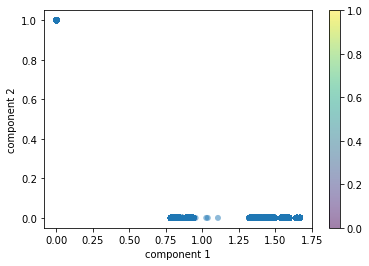

In [14]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

pca = TruncatedSVD(n_components=2)
projected = pca.fit_transform(X)

plt.scatter(projected[:, 0], projected[:, 1],
             edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.7)

In [16]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X1, y1)

y2_dummy = dummy.predict(X2)
accuracy_score(y2, y2_dummy)

0.4860452869931543

In [17]:
from sklearn.svm import SVC


model = SVC(kernel='linear')
model.fit(X1, y1)

y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.7200280849569949

In [18]:
objects.status.value_counts()

acquired       9394
live           4349
closed         2773
ipo            1134
beta            780
development     226
private         219
alpha           113
Name: status, dtype: int64